<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%204/Le%C3%A7on_4_Demo_detr2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Traitement fréquentiel

## Démo :  Détramage par filtrage ad hoc

### Référence : DIP 4e édition, Chapitre 5, « Periodic noise reduction using frequency domain filtering » p.340

Dans ce démo une image sera filtrée avec des filtres *notch* dans le domaine fréquentiel afin de retirer des artéfacts de scanning horizontal. Le bruit présent dans l’image est un bruit périodique affectant uniquement la direction horizontale. Il sera donc possible d’identifier dans la transformée de Fourier (TF) de l’image des régions à intensité élevée correspondant à la représentation spectrale du bruit. Un filtrage sélectif sera ensuite effectué pour atténuer le bruit sans affecter le contenu fréquentiel ne correspondant pas au bruit. Plus précisément, des filtres coupe-bande *notch* de type idéal et gaussien seront utilisés. Les filtres *notch* permettent une sélectivité encore plus grande que les filtres coupe- ou passe-bande.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (16,6)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

# Image originale et sa TF

La présence du bruit se manifeste dans le module de la TF de l’image par des pics de forte intensité centrés en x = 0 et distribués sur l’axe vertical (ceci est attendu considérant que les artéfacts sont des lignes horizontales). Une transformation logarithmique du module de la TF a été effectuée pour étaler la gamme des valeurs de plus faible intensité et permettre d’avoir un meilleur aperçu du contenu fréquentiel présent dans l’image.

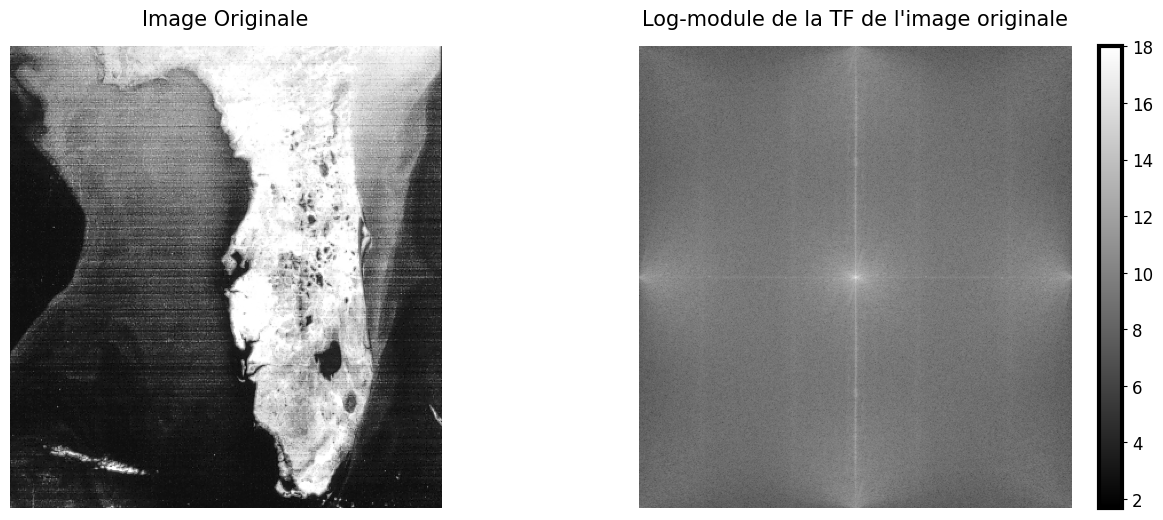

In [4]:
# Charger image
A = plt.imread('Repo/Data/Floride.tif');

# Transformée de Fourier
pad = 30;
Me, Ne = A.shape
AA = np.fft.fftshift(np.fft.fft2(np.double(A), (Me + pad, Ne + pad)))

plt.subplot(121); plt.imshow(A, cmap='gray'); plt.title('Image Originale'); plt.axis('off');
plt.subplot(122); plt.imshow(np.log(np.abs(AA)), cmap='gray'); plt.colorbar(); plt.title("Log-module de la TF de l'image originale"); plt.axis('off'); plt.show();

# Représentation fréquentielle des filtres

L’approche choisie est d’utiliser un filtre *notch* rectangulaire étroit en horizontal et s’étendant sur tout l’axe vertical sauf autour de l’origine. Ne pas filtrer trop proche de l’origine permet d’éviter d’éliminer le *dc term* et du contenu à basse fréquence qui ne correspond pas aux artéfacts. On peut voir que les bordures horizontales du filtre coupe-bande idéal sont plus abruptes que celles du filtre coupe-bande gaussien. Ces filtres sont multipliés à la TF de l’image avant d’effectuer une TF inverse pour obtenir l’image filtrée.

In [5]:
largeur = 7
fc = 10
l = np.floor(largeur/2);

M,N = AA.shape

M0 = np.ceil((M+1) / 2)
N0 = np.ceil((N+1) / 2)

U, V = np.mgrid[1:M+1, N0-l:N0+l+1]
D2 = (U - M0)**2

HHi = np.ones((M, N))
HHg = np.ones((M, N))


HHg[:, int(N0-l):int(N0+l+1)] = np.exp(-D2 / (2*fc**2))
HHi[:, int(N0-l):int(N0+l+1)] = D2 < fc**2

# filtrage gaussien
BBg = AA * HHg
Bg = np.fft.ifft2(np.fft.ifftshift(BBg))[:Me,:Ne]


# filtrage idéal
BBi = AA * HHi;
Bi = np.fft.ifft2(np.fft.ifftshift(BBi))[:Me,:Ne]

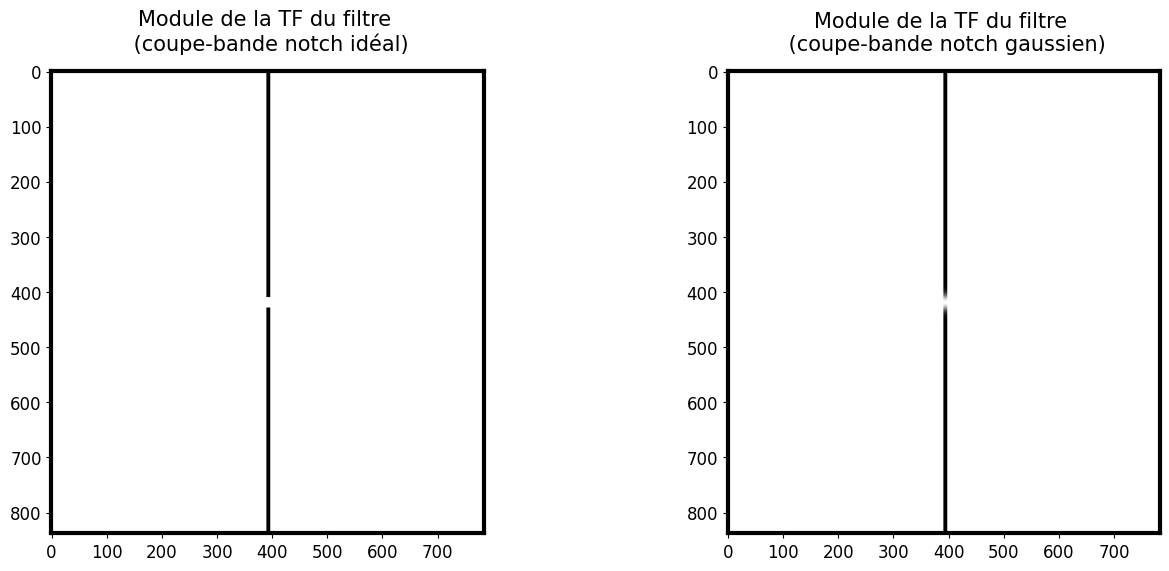

In [7]:
plt.subplot(121); plt.imshow(HHi, cmap='gray'); plt.title('Module de la TF du filtre \n (coupe-bande notch idéal)');
plt.subplot(122); plt.imshow(HHg, cmap='gray'); plt.title('Module de la TF du filtre \n (coupe-bande notch gaussien)');
plt.show()

# Résultats

Certains artéfacts sont encore visibles dans les régions à plus faible intensité mais dans l’ensemble, le filtrage coupe-bande *notch* a permis d’atténuer la majorité des lignes de scanning. De plus, ce filtrage sélectif a permis d’atténuer le bruit sans affecter de façon trop significative le contenu « important » de l’image, contrairement au filtre passe-bas utilisé dans le démo demo_detr avec la même image. Ce filtre atténuait toutes les basses fréquences sous la fréquence de coupure, ce qui lissait l’image et entraînait une importante perte de détails.

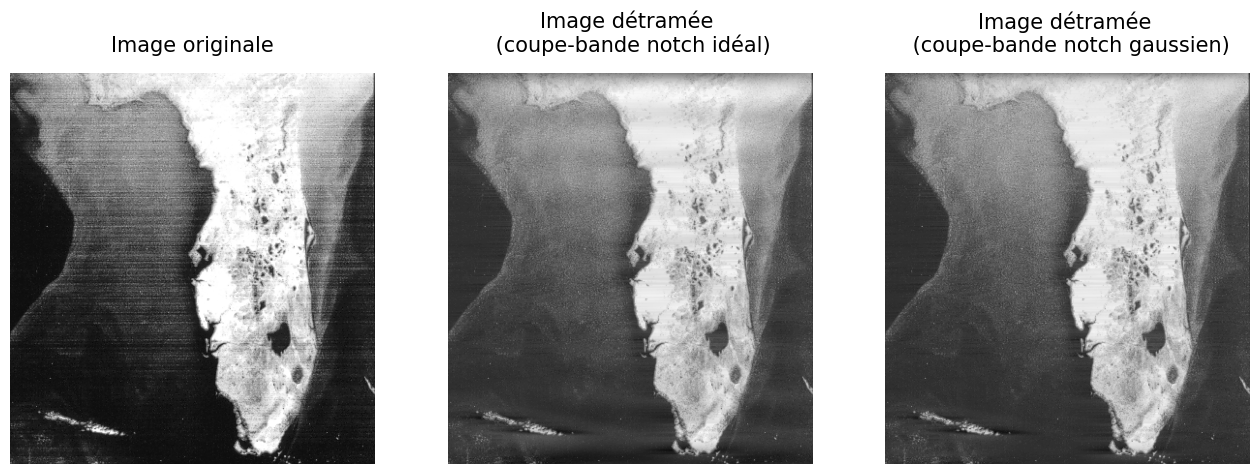

In [9]:
plt.subplot(131); plt.imshow(A, cmap='gray'); plt.title('Image originale'); plt.axis('off');
plt.subplot(132); plt.imshow(np.real(Bi), cmap='gray'); plt.axis('off'); plt.title('Image détramée \n (coupe-bande notch idéal)');
plt.subplot(133); plt.imshow(np.real(Bg), cmap='gray'); plt.axis('off'); plt.title('Image détramée \n (coupe-bande notch gaussien)');
plt.show()